In [1]:
# -------------------------------------------------------
#  Imports and basic setup
# -------------------------------------------------------
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

torch.manual_seed(1234)
np.random.seed(1234)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)


In [2]:
# -------------------------------------------------------
#  a 2‐D mixture of two Gaussians (equal weights assumption)
# -------------------------------------------------------
class TwoGaussianMixture:
    def __init__(self, means, base_var=1.0, weights=None, device="cpu"):
        """
        means: list of 2 tensors each of shape (2,)
        base_var: scalar variance for each component
        weights: optional list of 2 scalars for mixing; default [0.5,0.5]
        """
        self.means = means
        self.base_var = base_var
        if weights is None:
            self.weights = [0.5, 0.5]
        else:
            assert len(weights) == 2
            self.weights = weights
        self.device = device

    def log_prob(self, x, sigma):
        """
        Compute log p_sigma(x) where
        p_sigma(x) = 0.5*N(x; μ1, (base_var+σ^2)I) + 0.5*N(x; μ2, (base_var+σ^2)I).
        x: tensor (N,2)
        sigma: scalar
        Returns: log‐probabilities (N,)
        """
        total_var = self.base_var + sigma**2
        total_var = torch.tensor(total_var, device=device)
        d = x.shape[1]  # =2

        log_probs = []
        for mu, w in zip(self.means, self.weights):
            diff = x - mu.unsqueeze(0)  # (N,2)
            mah = -0.5 * (diff.pow(2).sum(dim=1) / total_var)
            norm = - (d/2) * torch.log(2 * torch.pi * total_var)
            log_comp = mah + norm + torch.log(torch.tensor(w, device=self.device))
            log_probs.append(log_comp.unsqueeze(1))  # shape (N,1)

        stacked = torch.cat(log_probs, dim=1)  # (N,2)
        return torch.logsumexp(stacked, dim=1)   # shape (N,)


# -------------------------------------------------------
#  Helper to sample from the “clean” (σ=0) mixture
# -------------------------------------------------------
def sample_from_clean_mixture(n_samples, means, base_var, device="cpu"):
    comp_choices = torch.bernoulli(0.5 * torch.ones(n_samples, device=device)).long()
    samples = []
    for k in comp_choices:
        mu = means[int(k)]
        z = torch.randn(2, device=device) * np.sqrt(base_var) + mu
        samples.append(z)
    return torch.stack(samples, dim=0)  # (n_samples,2)

In [3]:
# Create an instance
means = [
    torch.tensor([-3.0, -3.0], device=device),
    torch.tensor([+3.0, +3.0], device=device)
]
mixture = TwoGaussianMixture(means=means, base_var=1.0, device=device)

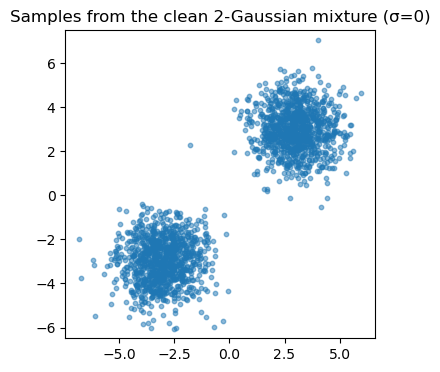

In [4]:
# -------------------------------------------------------
#  Visualize samples from the “clean” mixture
# -------------------------------------------------------
clean_X = sample_from_clean_mixture(2000, means, base_var=1.0, device=device).cpu().numpy()
plt.figure(figsize=(4,4))
plt.scatter(clean_X[:,0], clean_X[:,1], s=10, alpha=0.5)
plt.title("Samples from the clean 2‐Gaussian mixture (σ=0)")
plt.axis("equal")
plt.show()




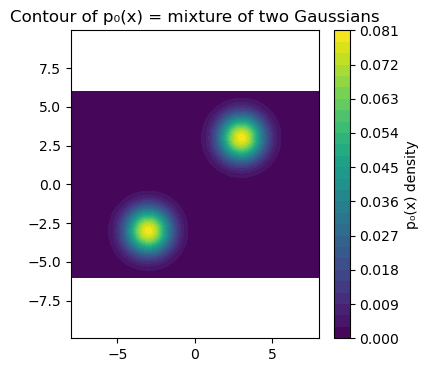

In [5]:
#  Contour‐plot of p0(x)
num_grid = 300
xx = np.linspace(-8, 8, num_grid)
yy = np.linspace(-6, 6, num_grid)
grid = np.stack(np.meshgrid(xx, yy), axis=-1).reshape(-1, 2)
grid_torch = torch.tensor(grid, device=device, dtype=torch.float32)
with torch.no_grad():
    logp0 = mixture.log_prob(grid_torch, sigma=0.0).cpu().numpy()
Z = logp0.reshape(num_grid, num_grid)

plt.figure(figsize=(4,4))
plt.contourf(xx, yy, np.exp(Z), levels=30, cmap="viridis")
plt.colorbar(label="p₀(x) density")
plt.title("Contour of p₀(x) = mixture of two Gaussians")
plt.axis("equal")
plt.show()




In [6]:
# -------------------------------------------------------
#  The “score function” ∇_x log p_σ(x) via autograd
# -------------------------------------------------------
def score_function(x, sigma, mixture):
    """
    Given x with requires_grad=True, compute ∇_x log p_sigma(x).
    x: Tensor (N,2) with requires_grad=True
    sigma: scalar
    mixture: instance of TwoGaussianMixture
    Returns: gradient (N,2)
    """
    x = x.clone().detach().requires_grad_(True)
    logp = mixture.log_prob(x, sigma)           # shape (N,)
    grad_x = torch.autograd.grad(
        outputs=logp.sum(),
        inputs=x,
        create_graph=False
    )[0]                        # shape (N,2)
    return grad_x




Langevin Diffusion

In [7]:
# -------------------------------------------------------
#  Run ULD (Unadjusted Langevin Dynamics) for several σ’s
# -------------------------------------------------------
sigmas = [0.5, 2.0, 5.0]
n_particles = 1024
langevin_steps = 1000
step_size = {0.5: 5e-4, 2.0: 1e-4, 5.0: 5e-5}

all_trajectories = {}

for sigma in sigmas:
    # Initialize from a broad Gaussian N(0, 4I)
    x_t = torch.randn(n_particles, 2, device=device) * 2.0
    trajectory = [x_t.detach().cpu().numpy()]

    eps = step_size[sigma]
    for t in range(langevin_steps):
        x_t.requires_grad_(True)
        score_xt = score_function(x_t, sigma, mixture)   # (N,2)

        noise = torch.randn_like(x_t)
        x_t = x_t + eps * score_xt + np.sqrt(2 * eps) * noise
        trajectory.append(x_t.detach().cpu().numpy())

    all_trajectories[sigma] = trajectory
    print(f"Finished Langevin for σ={sigma}")

        




Finished Langevin for σ=0.5
Finished Langevin for σ=2.0
Finished Langevin for σ=5.0


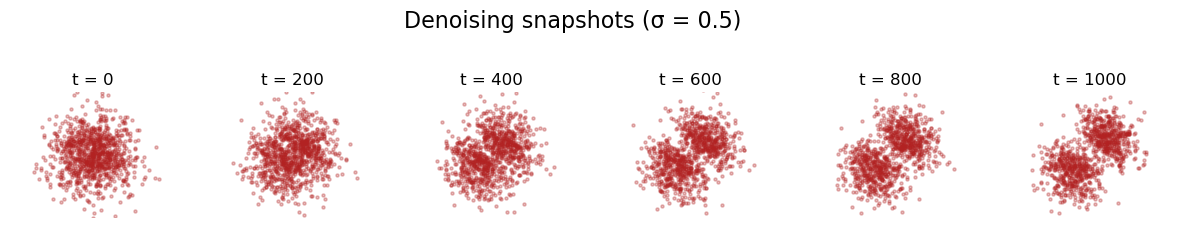

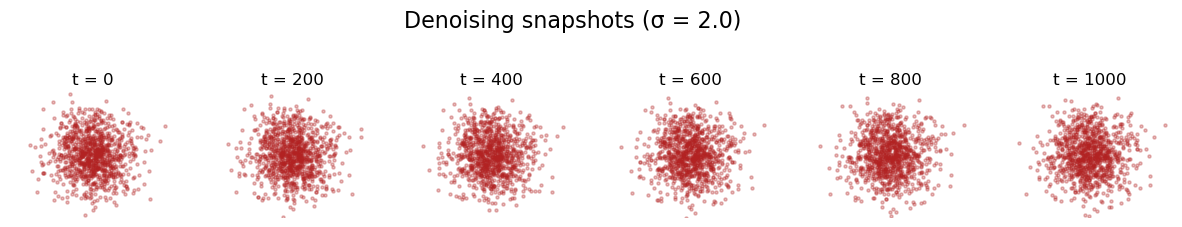

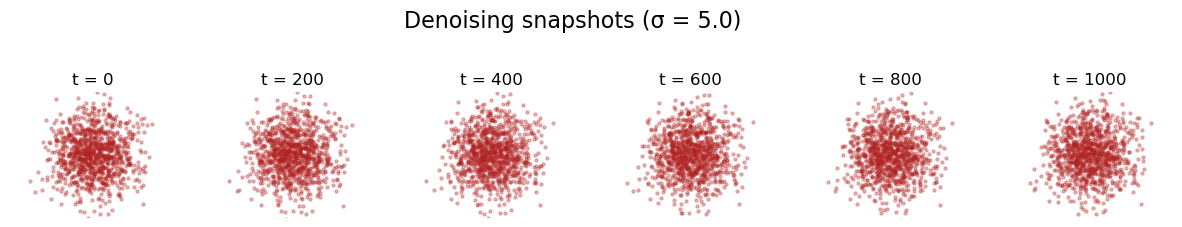

In [12]:
# -------------------------------------------------------
# Plot a few “snapshots” for each σ
# -------------------------------------------------------
def plot_snapshots_for_sigma(sigma, trajectory, n_snapshots=6):
    idxs = np.linspace(0, len(trajectory)-1, n_snapshots).astype(int)
    fig, axs = plt.subplots(1, n_snapshots, figsize=(15,3))
    for ax, idx in zip(axs, idxs):
        pts = trajectory[idx]
        ax.scatter(pts[:,0], pts[:,1], s=5, alpha=0.3, color='firebrick')
        ax.set_title(f"t = {idx}")
        ax.set_xlim(-8,8)
        ax.set_ylim(-6,6)
        ax.set_aspect("equal")
        ax.axis("off")
    plt.suptitle(f"Denoising snapshots (σ = {sigma})", fontsize=16)
    plt.show()

for sigma in sigmas:
    plot_snapshots_for_sigma(sigma, all_trajectories[sigma])

GIFs

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio               
import torch               
from torch.distributions import MultivariateNormal

plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams["font.size"] = 12

# (a) Define the “clean” 2-Gaussian mixture p0(x) in 2D.
#     Here μ1 = (-3, 0), μ2 = (+3, 0), each with identity covariance.
# mu1 = torch.tensor([-3.0, .0])
# mu2 = torch.tensor([+3.0, 0.0])
mu1=means[0]
mu2=means[1]
cov  = torch.eye(2)

gauss1 = MultivariateNormal(loc=mu1, covariance_matrix=cov)
gauss2 = MultivariateNormal(loc=mu2, covariance_matrix=cov)

def log_p0(x):
    """
    x: a (N,2) torch tensor
    returns: (N,) torch tensor of log p0(x) where
      p0(x) = 0.5 * N(x; mu1, I) + 0.5 * N(x; mu2, I)
    """
    # Evaluate each component's log‐pdf:
    l1 = gauss1.log_prob(x)   # shape (N,)
    l2 = gauss2.log_prob(x)   # shape (N,)
    # mixture: log(0.5 e^{l1} + 0.5 e^{l2})
    m  = torch.logaddexp(l1, l2)  # log(e^{l1} + e^{l2})
    return m + torch.log(torch.tensor(0.5))  # subtract log(2) → log(0.5)

def score_p0(x):
    """
    Returns the exact score ∇_x log p0(x).
    x: (N,2) tensor with requires_grad=True
    returns: (N,2) tensor containing ∇_x log p0(x).
    """
    x = x.clone().detach().requires_grad_(True)
    lp = log_p0(x).sum()
    grad_x = torch.autograd.grad(lp, x)[0]
    return grad_x

# (b) Given a “clean” point x, define the conditional noise‐corruption p_sigma(x̃ | x)
#     as N(x̃; x, σ^2 I).  Its score w.r.t. x̃ is (x - x̃) / σ^2.
def score_noisy(x_tilde, x_clean, sigma):
    """
    x_tilde: (N,2) tensor
    x_clean: (N,2) tensor
    sigma:  float
    returns (N,2) tensor = ∇_{x̃} log N(x̃; x_clean, σ² I) = (x_clean - x_tilde)/σ²
    """
    return (x_clean - x_tilde) / (sigma**2)

# =============================================================================
# 2) PART (1): BUILD AN ANIMATED GIF OF “DENOSING SNAPSHOTS”
#    (For each σ, we run Langevin dynamics from pure noise → mixture.)
# =============================================================================

def make_denoising_gif(
    sigma: float,
    n_particles: int = 1000,
    n_steps: int     = 1000,
    step_size: float = 1e-3,
    snapshot_interval: int = 200,
    gif_name: str    = "denoise_sigma.gif"
):
    """
    Runs Langevin dynamics on p_sigma(x) (the noise‐perturbed mixture).
    At each t = 0, 200, 400, …, 1000 we plot the current particles in red.
    Finally we save all frames into a single GIF file.
    """
    # 1) Initialize all particles at random (just plain N(0,I)):
    x = torch.randn(n_particles, 2)

    # 2) Pre‐compute any fixed noise that will be reused inside the loop:
    sqrt_eps = np.sqrt(step_size)

    frames = []
    for t in range(n_steps + 1):
        # EVERY snapshot_interval steps, record a frame:
        if t % snapshot_interval == 0:
            fig, ax = plt.subplots(figsize=(4,4))
            pts = x.detach().numpy()
            ax.scatter(pts[:,0], pts[:,1], s=10, color="tab:red", alpha=0.6)
            ax.set_xlim(-8, +8)
            ax.set_ylim(-8, +8)
            ax.set_title(f"t = {t},  σ = {sigma:.1f}")
            ax.set_xticks([])
            ax.set_yticks([])

            # Convert current figure to an image array in memory:
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(image)
            plt.close(fig)

        # 3) Compute one small Langevin step:
        #    Note: ∇ log p_sigma(x) = integral_y [ p(y) ∇_x log N(x; y, σ²I ) ] dy
        #    but we have “ground truth” for each particle:  we sample y ~ p(y) “on the fly”
        #    then compute ∇_{x} log p_sigma(x) ≈ E_{y~p(y)}[ (y - x) / σ² ].
        #    Since this is an academic example, we can simply draw one y_i per particle.
        #    => the exact vector is:
        #      score_psigma(x_i) = E_{y~p(y)}[ (y - x_i)/σ² ] ; approximate by 1 Monte Carlo sample.
        #
        #    Equivalently, you could computes scores in closed form by noticing:
        #      p_sigma(x) = ∫ p(y) N(x; y, σ² I) dy  (convolution of mixture with Gaussian)
        #    and then differentiate log p_sigma(x) exactly.  Either way is OK,
        #    but we’ll just Monte Carlo‐estimate for simplicity.

        #    Draw one “clean” y for each particle (so that E_{y}[·] is unbiased):
        y_samples = torch.zeros(n_particles, 2)
        #   half from component1, half from component2:
        half = n_particles // 2
        y_samples[:half]  = mu1 + torch.randn(half, 2)  # N(mu1, I)
        y_samples[half:]  = mu2 + torch.randn(n_particles-half, 2)  # N(mu2, I)

        #    Score ≈ (y - x)/σ²:
        scores = (y_samples - x) / (sigma**2)

        #    Langevin update:
        noise  = torch.randn_like(x) * sqrt_eps
        x     += 0.5 * step_size * scores + noise

    # 4) Write the frames into a GIF file:
    imageio.mimsave(gif_name, frames, fps=5)
    print(f"✅ Saved GIF → {gif_name}  (frames: {len(frames)})")


# === RUN GIF CREATION FOR σ = 0.5, 2.0, 5.0 === 
#     (You can change sigma_list or parameters as you wish.)

sigma_list = [0.5, 2.0, 5.0]
for sigma in sigma_list:
    gif_filename = f"denoise_sigma{sigma:.1f}.gif"
    make_denoising_gif(
        sigma=sigma,
        n_particles=2000,
        n_steps=1000,
        step_size=1e-3,
        snapshot_interval=200,
        gif_name=gif_filename
    )

/var/folders/zq/4xn1rwdn51v2kstjl32rry940000gn/T/ipykernel_1785/439220889.py:96: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


✅ Saved GIF → denoise_sigma0.5.gif  (frames: 6)
✅ Saved GIF → denoise_sigma2.0.gif  (frames: 6)
✅ Saved GIF → denoise_sigma5.0.gif  (frames: 6)


Plots the noise‐conditional densities p𝜎i(x) and their score‐vector fields (arrows) at three different noise‐levels 
𝜎1,𝜎2 and 𝜎3 (exactly as in the “NCSM” slide)

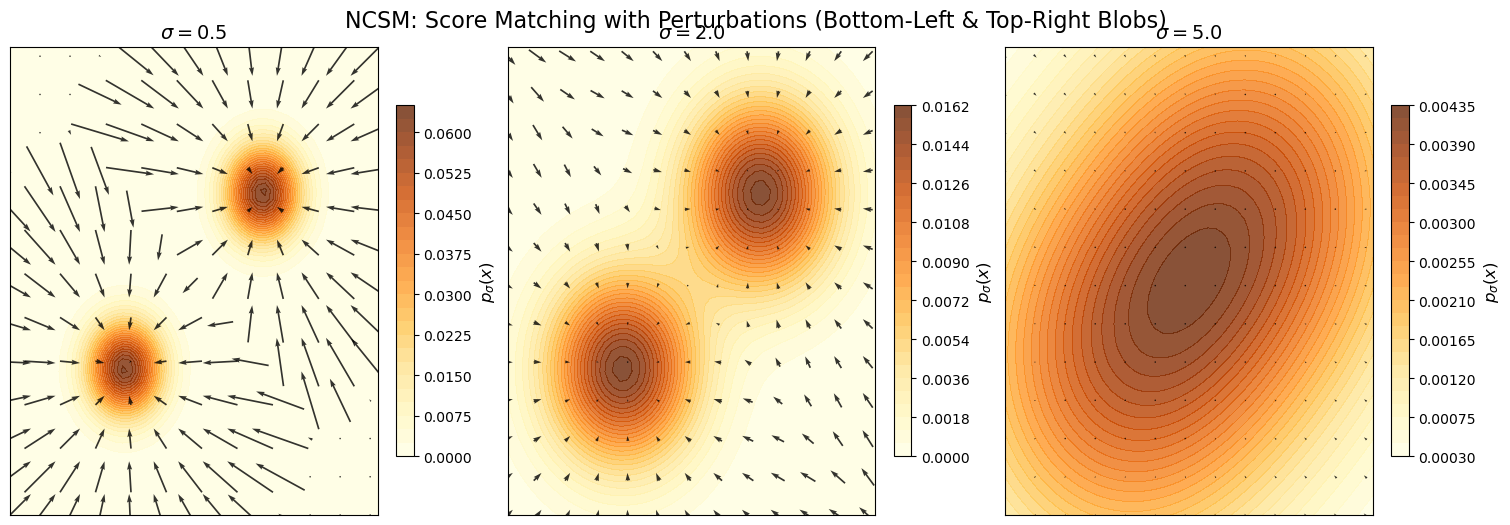

In [9]:

# REPRODUCE SLIDE  #46──────────────────────────────────────────────────────────────────────────────
# 1) Define the “clean” 2‐Gaussian mixture and its σ‐perturbed version analytically
# ──────────────────────────────────────────────────────────────────────────────

# Place the two “clean” Gaussians at bottom-left and top-right:
mu1 = np.array([-3.0, -3.0])
mu2 = np.array([+3.0, +3.0])

I2  = np.eye(2)

def exact_p_sigma(x, sigma):
    """
    Compute p_σ(x) = ∫ p₀(y) * N(x; y, σ² I) dy exactly,
    where p₀(y) = ½·N(y;μ₁,I) + ½·N(y;μ₂,I).  Convolution
    of two Gaussians just adds covariances, so each mixture
    component becomes N(x;μ_i, (1+σ²)I).
    """
    cov = (1.0 + sigma**2) * I2
    invcov = np.linalg.inv(cov)
    logdet = np.log(np.linalg.det(cov))

    def log_gauss(x, mu):
        # x: (M,2), mu: (2,)
        dx = x - mu              # (M,2)
        quad = np.sum((dx @ invcov) * dx, axis=1)  # (M,)
        # log N(x; μ, cov) = -½[ d·log(2π) + log|cov| + (x-μ)^T cov⁻¹ (x-μ) ]
        return -0.5 * (2*np.log(2*np.pi) + logdet + quad)

    lg1 = log_gauss(x, mu1)  # (M,)
    lg2 = log_gauss(x, mu2)  # (M,)
    m   = np.logaddexp(lg1, lg2)  # log(e^{lg1}+e^{lg2})
    return np.exp(m + np.log(0.5))  # ½·(e^{lg1} + e^{lg2})

def exact_score_sigma(x, sigma):
    """
    Compute ∇_x log p_σ(x) in closed-form:
      p_σ(x) = ½ N(x;μ₁,(1+σ²)I) + ½ N(x;μ₂,(1+σ²)I).
    Then
      ∇ log p_σ(x) = [ w₁·∇ log N(x;μ₁,...) + w₂·∇ log N(x;μ₂,...) ],
    where w_i = N(x;μ_i)/(N(x;μ₁)+N(x;μ₂)).  
    """
    cov    = (1.0 + sigma**2) * I2
    invcov = np.linalg.inv(cov)

    def gauss_pdf(x, mu):
        dx   = x - mu
        quad = np.sum((dx @ invcov) * dx, axis=1)  # (M,)
        logZ = 0.5 * (2*np.log(2*np.pi) + np.log(np.linalg.det(cov)))
        return np.exp(-0.5*quad - logZ)             # (M,)

    def gauss_score(x, mu):
        # ∇_x log N(x; μ, cov) = -cov⁻¹ (x-μ)
        return -(x - mu) @ invcov                  # (M,2)

    p1 = gauss_pdf(x, mu1)   # (M,)
    p2 = gauss_pdf(x, mu2)   # (M,)
    s1 = gauss_score(x, mu1) # (M,2)
    s2 = gauss_score(x, mu2) # (M,2)

    denom = p1 + p2 + 1e-12  # avoid division by zero
    w1    = p1 / denom       # (M,)
    w2    = p2 / denom       # (M,)
    return (w1[:,None] * s1 + w2[:,None] * s2)  # (M,2)


# ──────────────────────────────────────────────────────────────────────────────
# 2) Build a 50×50 grid in [−8,8]×[−8,8], evaluate p_σ and ∇ log p_σ, then plot all
#    three σ‐values side by side.
# ──────────────────────────────────────────────────────────────────────────────

# Create a uniform 50×50 mesh of points in [−8,8]^2:
grid_n = 50
xx  = np.linspace(-8, +8, grid_n)
yy  = np.linspace(-8, +8, grid_n)
X, Y = np.meshgrid(xx, yy)
pts  = np.stack([X.ravel(), Y.ravel()], axis=1)  # shape (grid_n^2, 2)

σ_list = [0.5, 2.0, 5.0]

# Create one figure with three subplots (horizontal layout)
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(15, 5),
    constrained_layout=True
)

for ax, sigma in zip(axes, σ_list):
    #  Compute exact p_σ(x) and ∇ log p_σ(x) on all 2500 grid points at once:
    p_flat = exact_p_sigma(pts, sigma)     # (grid_n^2,)
    score  = exact_score_sigma(pts, sigma) # (grid_n^2, 2)

    # Reshape to (grid_n, grid_n) for contour and quiver
    dens = p_flat.reshape(grid_n, grid_n)
    sx   = score[:,0].reshape(grid_n, grid_n)
    sy   = score[:,1].reshape(grid_n, grid_n)

    # Draw a filled contour of p_σ(x)
    cf = ax.contourf(
        X, Y, dens,
        levels=30,
        cmap=cm.YlOrBr,
        alpha=0.8
    )
    #  a colorbar to each subplot:
    cbar = fig.colorbar(cf, ax=ax, shrink=0.75, label=r"$p_{\sigma}(x)$")
    cbar.ax.tick_params(labelsize=10)

    #  Overlay quiver‐plot of ∇ log p:
    stride = 4
    ax.quiver(
        X[::stride, ::stride],
        Y[::stride, ::stride],
        sx[::stride, ::stride],
        sy[::stride, ::stride],
        color="k",
        pivot="mid",
        scale=35,
        alpha=0.8
    )

    ax.set_title(rf"$\sigma = {sigma:.1f}$", fontsize=14)
    ax.set_xlim(-8, +8)
    ax.set_ylim(-8, +8)
    ax.set_xticks([])
    ax.set_yticks([])

#  a common super‐title:
fig.suptitle("NCSM: Score Matching with Perturbations (Bottom‐Left & Top‐Right Blobs)", 
             fontsize=16, y=1.02)

# ──────────────────────────────────────────────────────────────────────────────
#  Save the combined figure to disk
# ──────────────────────────────────────────────────────────────────────────────


fig.savefig("ncsms_side_by_side.png", dpi=150, bbox_inches="tight")


